# Iterative Random Forest Prediction
### Using Bachelorette Data, Predicts the Winner Each Week

In [1]:
# load in libraries
import pandas as pd
import numpy as np
%matplotlib inline
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os

In [2]:
# load in data file
ette_all = pd.read_csv('bachelorette_forprediction.csv')

## Functions

#### Weighting Variables

In [3]:
def weighting(data_set, current_week, varlist):
    n = 1
    
    #print(current_week)
    while current_week > 0: 
        varcount = 0
        for each in varlist: 
            if varcount < 3: 
                varuse = each + str(current_week)
                data_set[varuse] = data_set[varuse] * n
            else: 
                varuse = str(current_week + 1) + each
                data_set[varuse] = data_set[varuse] * n
            varcount = varcount + 1
            
        current_week = current_week - 1
        n = n - 0.1
    
    return(data_set)

#### Prediction System

In [4]:

# weighting choice - 1 = do weights, 0 = don't
# wtc = 0 = WINNER, 1 = Top 3
# senti = 0 = no sentiment, 1 = use sentiment
# comb = 0 then full set, 1 = past/current
def prediction_system(test_bach, train_bach, weighting_choice, wtc, senti, comb, model_choice):
    week = 1
    
    if wtc == 0: 
        # 'Occupation', 'Agreement_1', 'Hometown'
        vars_to_use = ['WINNER', 'NAME', 'AGE', 'AGE_DIFF_CAT', 'SAME_STATE', 'SAME_REGION', 'SAME_OCCUPATIONGROUP'] ### will need  to add other relevant predictor variables 
        keep_set = test_bach[['NAME', 'WINNER']].copy()
    if wtc == 1: 
        vars_to_use = ['TOP_THREE', 'NAME', 'AGE', 'AGE_DIFF_CAT', 'SAME_STATE', 'SAME_REGION', 'SAME_OCCUPATIONGROUP']
        keep_set = test_bach[['NAME', 'TOP_THREE']].copy()
        
        
    while week <= 10: # ten weeks of data available

        fir = 'FIR-'
        rose = 'ROSE-'
        dates = 'DATES-'
        if senti == 1:
            neg = '.0-Negative'
            pos = '.0-Positive'
            neu = '.0-Neutral'
            tot = '.0-Total'
            choose = '.0-choose'
            win = '.0-win'
            sentis = [neg, pos, neu, tot, choose, win]
        if comb == 1: 
            pastneg = 'PAST_NEG_'
            pastpos = 'PAST_POS_'
            pastneu = 'PAST_NEU_'
            pasttot = 'PAST_TOT_'
            pastchoose = 'PAST_CHOOSE_'
            pastwin = 'PAST_WIN_'
            pasts = [pastneg, pastpos, pastneu, pasttot, pastchoose, pastwin]

        if senti == 1: 
            varlist = [fir, rose, dates, neg, pos, neu, tot, choose, win]
        if senti == 0: 
            varlist = [fir, rose, dates]

        new_var = fir + str(week)
        vars_to_use.append(new_var)

        new_var2 = rose + str(week)
        vars_to_use.append(new_var2)

        new_var3 = dates + str(week)
        vars_to_use.append(new_var3)
        
        if senti == 1 and comb == 0: 
            new_var4 = str(week + 1) + neg
            vars_to_use.append(new_var4)

            new_var5 = str(week + 1) + pos 
            vars_to_use.append(new_var5)

            new_var6 = str(week + 1) + neu
            vars_to_use.append(new_var6)

            new_var7 = str(week + 1) + tot 
            vars_to_use.append(new_var7)

            new_var8 = str(week + 1) + choose 
            vars_to_use.append(new_var8)

            new_var9 = str(week + 1) + win 
            vars_to_use.append(new_var9)
            
            
        if senti == 1 and comb == 1 and week <= 2: 
            # add in current week numbers
            # remove past weeks
            # include PASTs
            
            for each in sentis: 
                
                new_var4 = str(week + 1) + each
                vars_to_use.append(new_var4)
                    
        if senti == 1 and comb == 1 and week == 3: 
            # add in current week numbers
            # remove past weeks
            # include PASTs
            
            for each in sentis: 
                
                new_var4 = str(week + 1) + each
                vars_to_use.append(new_var4)
                
                new_var4 = str(week) + each
                vars_to_use.remove(new_var4)
            
                new_var4 = str(week - 1) + each
                vars_to_use.remove(new_var4)
            
            for each in pasts: 
                new_var4 = each + str(week + 1) 
                vars_to_use.append(new_var4)
                
                #if week > 3: 
                #    new_var4 = each + str(week - 1)
                #    vars_to_use.remove(new_var4)
                    
            
        if senti == 1 and comb == 1 and week > 3: 
            # add in current week numbers
            # remove past weeks
            # include PASTs
            
            for each in sentis: 
                
                new_var4 = str(week + 1) + each
                vars_to_use.append(new_var4)
                
                new_var4 = str(week) + each
                vars_to_use.remove(new_var4)
            
                #new_var4 = str(week - 1) + each
                #vars_to_use.remove(new_var4)
            
            for each in pasts: 
                new_var4 = each + str(week + 1) 
                vars_to_use.append(new_var4)
                
                
                new_var4 = each + str(week)
                vars_to_use.remove(new_var4)
            
        if model_choice == 1: 
            # Random Forest model
            the_model = skens.RandomForestClassifier(n_estimators=1000,oob_score=True, criterion='entropy')
        if model_choice == 0: 
            # Naive Bayes model
            the_model = sknb.GaussianNB()
        
        # train on correct variables based on week
        ### need 'WINNER' binary as right/wrong
        this_train = train_bach[vars_to_use].copy()
        if weighting == 1: 
            this_train = weighting(this_train, week, varlist)
        #print(week)
        #print(vars_to_use)

        # train model on our train set
        if wtc == 0: 
            the_model.fit(this_train[vars_to_use[2:]], this_train.WINNER)
        if wtc == 1: 
            the_model.fit(this_train[vars_to_use[2:]], this_train.TOP_THREE)
            
        # set up test set
        this_test = test_bach[vars_to_use].copy()
        if weighting == 1:
            this_test = weighting(this_test, week, varlist)

        # test on correct variables based on week
        # hide winners
        predicted_labels = the_model.predict(this_test[vars_to_use[2:]])

        # add in predictions
        pred_week = 'PREDICTED' + str(week)
        this_test[pred_week] = predicted_labels
        if wtc == 0:
            to_output = this_test[['NAME', 'WINNER', pred_week]].copy()
            keep_set = keep_set.merge(to_output, on = ['NAME', 'WINNER'], how = 'left')
        if wtc == 1: 
            to_output = this_test[['NAME', 'TOP_THREE', pred_week]].copy()
            keep_set = keep_set.merge(to_output, on = ['NAME', 'TOP_THREE'], how = 'left')
            
        # remove contestants based on ELIMINATION
        e_week_name = 'ELIMINATION-' + str(week)

        # keep them if their elimination value is null or is R (rose)
        test_bach = test_bach[(test_bach[e_week_name].isnull()) | (test_bach[e_week_name] == 'R') | (test_bach[e_week_name] == 'R1')]
        train_bach = train_bach[(train_bach[e_week_name].isnull()) | (train_bach[e_week_name] == 'R') | (train_bach[e_week_name] == 'R1')]
        #print(len(test_bach))
        #print(len(train_bach))

        # increment time
        week = week + 1
        
    return(keep_set)


#### Evaluation Metric Calculation

In [5]:
# accuracy = (true positive + true negative) / total examples
# true positive = WINNER == 1 and PREDICTED == 1
# true negative = WINNER == 0 and PREDICTED == 0
# total examples = count(PREDICTED)
# wtc = 0 = WINNER, 1 = Top 3

def metric_calc(keep_set, wtc):
    week = 1
    metrics = {}
    
    if wtc == 0: 
        vari = 'WINNER'
    if wtc == 1: 
        vari = 'TOP_THREE'
        
    while week <= 10:
        tp = 'TRUE_POSITIVE_' + str(week)
        tn = 'TRUE_NEGATIVE_' + str(week)
        fp = 'FALSE_POSITIVE_' + str(week)
        fn = 'FALSE_NEGATIVE_' + str(week)
        predict_use = 'PREDICTED' + str(week)
        keep_set[tp] = np.where((keep_set[vari] == 1) & (keep_set[predict_use] == 1), 1, 0)
        keep_set[tn] = np.where((keep_set[vari] == 0) & (keep_set[predict_use] == 0), 1, 0)
        keep_set[fp] = np.where((keep_set[vari] == 0) & (keep_set[predict_use] == 1), 1, 0)
        keep_set[fn] = np.where((keep_set[vari] == 1) & (keep_set[predict_use] == 0), 1, 0)

        total_examples = keep_set[predict_use].count()

        accuracy = (keep_set[tp].sum() + keep_set[tn].sum()) / total_examples
        accuracy_use = 'ACCURACY_' + str(week)
        metrics[accuracy_use] = accuracy

        precision = keep_set[tp].sum() / (keep_set[tp].sum() + keep_set[fp].sum())
        precision_use = 'PRECISION_' + str(week)
        metrics[precision_use] = precision

        recall = keep_set[tp].sum() / (keep_set[tp].sum() + keep_set[fn].sum())
        recall_use = 'RECALL_' + str(week)
        metrics[recall_use] = recall

        f1 = 2 * ((precision * recall)/(precision + recall))
        f1_use = 'F1_'+ str(week)
        metrics[f1_use] = f1

        week = week + 1

    evaluation = pd.DataFrame(metrics, index=range(len(metrics)))
    evaluation = pd.DataFrame(evaluation.iloc[0])
    evaluation['Category'] = evaluation.index
    evaluation[['Metric', 'Week']] = evaluation['Category'].str.split('_',expand=True)
    evaluation = evaluation[['Metric', 'Week', 0]]
    evaluation.columns = ['Metric', 'Week', 'Value']
    
    return(evaluation)


#### Plotting Evaluation Metrics

In [21]:
#save indicates whether to save or not, default is 0, to save, set save = 1
def plot_metrics(data_bit,Title,save = 0):    
    fig = plt.figure(figsize=(20,10))

    plt.subplot(221)
    plt.plot("Week", "Value", data=data_bit[data_bit.Metric == 'PRECISION'], linestyle='-', marker='o')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.5,10)
    plt.title('PRECISION')

    plt.subplot(223)
    plt.plot("Week", "Value", data=data_bit[data_bit.Metric == 'ACCURACY'], linestyle='-', marker='o')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.5,10)
    plt.title('ACCURACY')

    plt.subplot(222)
    plt.plot("Week", "Value", data=data_bit[data_bit.Metric == 'RECALL'], linestyle='-', marker='o')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.5,10)
    plt.title('RECALL')

    plt.subplot(224)
    plt.plot("Week", "Value", data=data_bit[data_bit.Metric == 'F1'], linestyle='-', marker='o')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.5,10)
    plt.title('F1')
    
    fig.suptitle(Title, fontsize=16)

    if save == 1:
        plt.savefig(Title)
    
    plt.show()
# # 
#     for each_type in metric_types: 
#         plt.plot("Week", "Value", data=data_bit[data_bit.Metric == each_type], linestyle='-', marker='o')
#         plt.ylim(-0.1,1.1)
#         plt.xlim(-0.5,10)
#         plt.title(each_type)
#         plt.show()

## Code to Run

In [23]:
# weighting choice - 1 = do weights, 0 = don't
# wtc = 0 = WINNER, 1 = Top 3
# senti = 0 = no sentiment, 1 = use sentiment
# comb = 0 then full set, 1 = past/current
# model_choice = 1 for random forest, 0 for naive bayes
#def prediction_system(test_bach, train_bach, weighting_choice, wtc, senti, comb, model_choice):

test_bach = ette_all[ette_all.SEASON == 14].copy()
train_bach = ette_all[ette_all.SEASON != 14].copy()

keep_set = prediction_system(test_bach, train_bach, 0, 0, 0, 0, 1)

In [24]:
# wtc = 0 = WINNER, 1 = Top 3
# def metric_calc(keep_set, wtc):

top3numbers = metric_calc(keep_set, 0)
top3numbers

C:\Users\julie\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in longlong_scalars


,Metric,Week,Value
ACCURACY_1,ACCURACY,1,0.964286
PRECISION_1,PRECISION,1,NaN
RECALL_1,RECALL,1,0.000000
F1_1,F1,1,NaN
ACCURACY_2,ACCURACY,2,0.952381
PRECISION_2,PRECISION,2,NaN
RECALL_2,RECALL,2,0.000000
F1_2,F1,2,NaN
ACCURACY_3,ACCURACY,3,0.944444
PRECISION_3,PRECISION,3,NaN


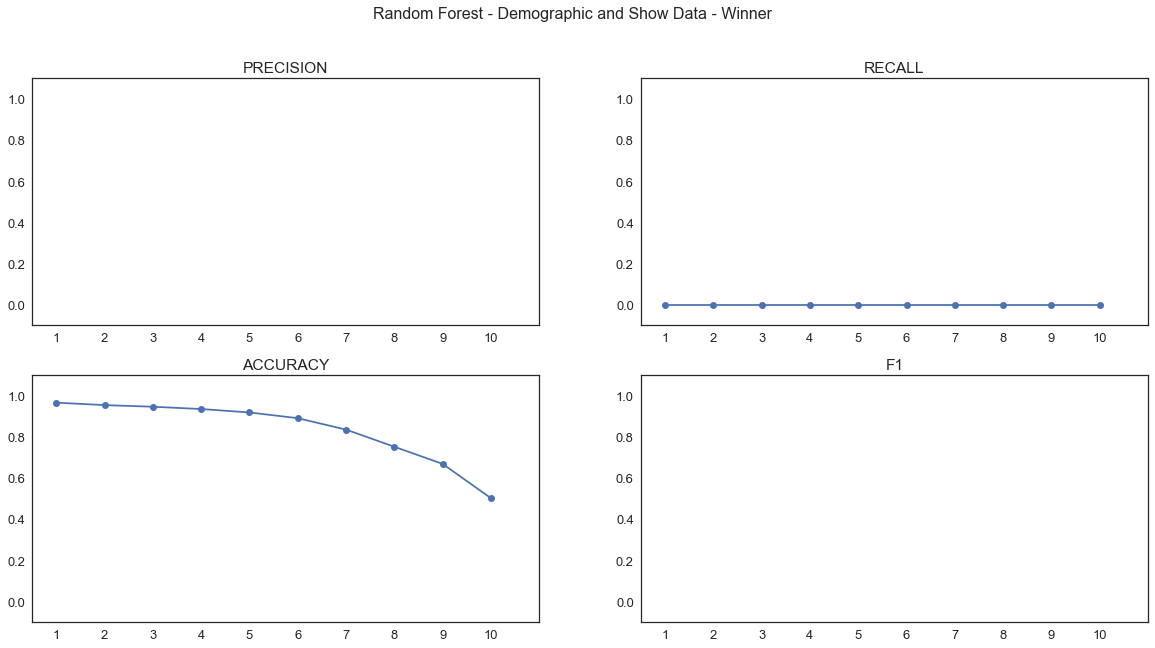

In [25]:
plot_metrics(top3numbers, "Random Forest - Demographic and Show Data - Winner", 1)

In [13]:
#'PAST_NEG_4', 'PAST_POS_4', 'PAST_NEU_4', 'PAST_TOT_4', 'PAST_CHOOSE_4', 'PAST_WIN_4' --> 11
past_bit = ette_all[['NAME', 'SEASON', 'PAST_NEG_4', 'PAST_POS_4', 'PAST_NEU_4', 'PAST_TOT_4', 'PAST_CHOOSE_4', 'PAST_WIN_4', 
                     'PAST_NEG_5', 'PAST_POS_5', 'PAST_NEU_5', 'PAST_TOT_5', 'PAST_CHOOSE_5', 'PAST_WIN_5', 
                    'PAST_NEG_6', 'PAST_POS_6', 'PAST_NEU_6', 'PAST_TOT_6', 'PAST_CHOOSE_6', 'PAST_WIN_6', 
                    'PAST_NEG_7', 'PAST_POS_7', 'PAST_NEU_7', 'PAST_TOT_7', 'PAST_CHOOSE_7', 'PAST_WIN_7', 
                    'PAST_NEG_8', 'PAST_POS_8', 'PAST_NEU_8', 'PAST_TOT_8', 'PAST_CHOOSE_8', 'PAST_WIN_8', 
                    'PAST_NEG_9', 'PAST_POS_9', 'PAST_NEU_9', 'PAST_TOT_9', 'PAST_CHOOSE_9', 'PAST_WIN_9', 
                    'PAST_NEG_10', 'PAST_POS_10', 'PAST_NEU_10', 'PAST_TOT_10', 'PAST_CHOOSE_10', 'PAST_WIN_10',
                    'PAST_NEG_11', 'PAST_POS_11', 'PAST_NEU_11', 'PAST_TOT_11', 'PAST_CHOOSE_11', 'PAST_WIN_11']]
past_bit = pd.melt(past_bit, id_vars=['NAME', 'SEASON'])
past_bit.head()

,NAME,SEASON,variable,value
0,Garrett Yrigoyen,14,PAST_NEG_4,14.5
1,Blake Horstmann,14,PAST_NEG_4,10.0
2,Jason Tartick,14,PAST_NEG_4,2.5
3,Colton Underwood,14,PAST_NEG_4,31.5
4,Wills Reid,14,PAST_NEG_4,1.0


In [16]:
past_bit['VARIABLE'], past_bit['WEEK'] = past_bit['variable'].str.split('_', 1).str

In [18]:
past_bit['VARIABLE'], past_bit['WEEK'] = past_bit['WEEK'].str.split('_', 1).str
past_bit.head()

,NAME,SEASON,variable,value,VARIABLE,WEEK
0,Garrett Yrigoyen,14,PAST_NEG_4,14.5,NEG,4
1,Blake Horstmann,14,PAST_NEG_4,10.0,NEG,4
2,Jason Tartick,14,PAST_NEG_4,2.5,NEG,4
3,Colton Underwood,14,PAST_NEG_4,31.5,NEG,4
4,Wills Reid,14,PAST_NEG_4,1.0,NEG,4


In [25]:
past_bit[["NAME", "SEASON", "VARIABLE", "value", "WEEK"]].to_csv("past_cumulative_vars.csv")